### Problem Statement: Cricket Batsman Performance Analysis

The objective is to create a data analysis workflow to evaluate a cricket batsman's performance based on their ball-by-ball scoring data. The analysis will focus on calculating three key performance indicators:

1.  **Strike Rate**: The average number of runs scored per 100 balls faced.
    *   *Formula*: `(Total Runs Scored / Total Balls Faced) * 100`

2.  **Boundary Percentage**: The percentage of a batsman's total runs that come from boundaries (i.e., fours and sixes).
    *   *Formula*: `(Runs from Boundaries / Total Runs Scored) * 100`

3.  **Balls per Boundary**: The average number of balls a batsman faces for every boundary they hit.
    *   *Formula*: `Total Balls Faced / Number of Boundaries Hit`

The workflow should process a given sequence of runs and output these three metrics.


In [1]:
# standards imports
from typing import TypedDict

# third-party imports
from langgraph.graph import StateGraph, START, END


In [2]:
# state-class 

class BatsmanState(TypedDict):
    """Represents the state of a batsman's performance analysis.

    Attributes:
        runs (int): Total runs scored by the batsman.
        balls (int): Total balls faced by the batsman.
        fours (int): Number of boundaries (4s) hit by the batsman.
        sixes (int): Number of boundaries (6s) hit by the batsman.
        strike_rate (float): The calculated strike rate.
        balls_per_boundary (float): The calculated balls per boundary.
        boundary_percentage (float): The calculated boundary percentage.
        summary (str): A textual summary of the batsman's performance.
    """
    runs : int
    balls : int
    fours : int
    sixes : int
    
    strike_rate : float
    balls_per_boundary : float
    boundary_percentage : float
    
    summary : str

In [6]:
# graphs nodes 

# calculate strike rate
def strike_rate_fun(state: BatsmanState):
    """Calculates the strike rate of the batsman.

    Args:
        state (BatsmanState): The current state of the batsman's performance, containing 'runs' and 'balls'.

    Returns:
        dict: The updated state with the 'strike_rate' calculated.
    """
    runs = state['runs']
    balls = state['balls']
    
    if balls > 0:
        strike_rate = (runs / balls) * 100
    else:
        strike_rate = 0.0
    
    state['strike_rate'] = strike_rate
    return state

# calculate balls per boundary
def balls_per_boundary_fun(state: BatsmanState):
    """Calculates the balls per boundary for the batsman.

    Args:
        state (BatsmanState): The current state of the batsman's performance, containing 'balls', 'sixes', and 'fours'.

    Returns:
        dict: The updated state with 'balls_per_boundary' calculated.
    """
    balls = state['balls']
    sixes = state["sixes"]
    fours = state["fours"]
    
    total_boundaries = sixes + fours
    if total_boundaries > 0:
        balls_per_boundary = balls / total_boundaries
    else:
        balls_per_boundary = 0.0
        
    state['balls_per_boundary'] = balls_per_boundary
    return state

# calculate boundary percentage
def  boundary_percentage_fun(state: BatsmanState):
    """Calculates the boundary percentage for the batsman.

    Args:
        state (BatsmanState): The current state of the batsman's performance, containing 'runs', 'sixes', and 'fours'.

    Returns:
        dict: The updated state with 'boundary_percentage' calculated.
    """
    runs = state["runs"]
    sixes = state["sixes"]
    fours = state["fours"]
    
    runs_from_boundaries = (sixes * 6) + (fours * 4)
    
    if runs > 0:
        boundary_percentage = (runs_from_boundaries / runs) * 100
    else:
        boundary_percentage = 0.0
        
    state['boundary_percentage'] = boundary_percentage
    return state


# write the summary
def summary_fun(state: BatsmanState):
    """Generates a summary of the batsman's performance.

    Args:
        state (BatsmanState): The current state of the batsman's performance, 
                              containing 'strike_rate', 'balls_per_boundary', and 'boundary_percentage'.

    Returns:
        dict: The updated state with the 'summary' field populated.
    """
    
    summary = f""" 
    Strike rate = {state["strike_rate"]:.2f},
    Balls per Boundary = {state["balls_per_boundary"]:.2f},
    Boundary percentage = {state["boundary_percentage"]:.2f},
    """
    state["summary"] = summary
    return state

In [9]:
# graph 
graph = StateGraph(BatsmanState)

# Add nodes to the graph
graph.add_node("strike_rate", strike_rate_fun)
graph.add_node("balls_per_boundary", balls_per_boundary_fun)
graph.add_node("boundary_percentage", boundary_percentage_fun)
graph.add_node("summary", summary_fun)

# level - 1: Start and run calculations in parallel
graph.add_edge(START, "strike_rate")
graph.add_edge(START, "balls_per_boundary")
graph.add_edge(START, "boundary_percentage")

# level - 2: Converge to summary
graph.add_edge("strike_rate", "summary")
graph.add_edge("balls_per_boundary", "summary")
graph.add_edge("boundary_percentage", "summary")

# level - 3: End after summary
graph.add_edge("summary", END)

workflow = graph.compile()

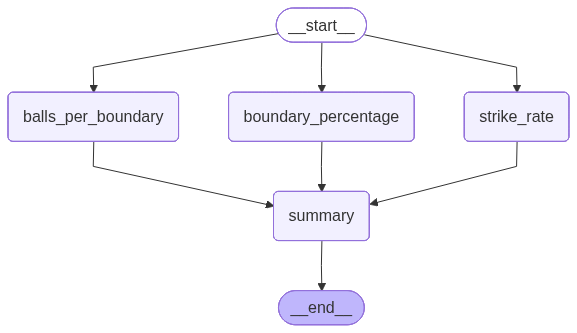

In [10]:
workflow

In [11]:
initial_state = {
    'runs'  : 45,
    'balls' : 32,
    'fours' : 2,
    'sixes' : 4
    
}

workflow.invoke(initial_state)

InvalidUpdateError: At key 'runs': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/INVALID_CONCURRENT_GRAPH_UPDATE

---

The following error is caused because all the nodes are sending state updates at the same time, and instead of the values/states being merged correctly, they are overlapping. This leads to multiple updates being sent to the same key within a single step, which triggers the following error:

InvalidUpdateError: At key 'runs': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: [https://docs.langchain.com/oss/python/langgraph/errors/INVALID_CONCURRENT_GRAPH_UPDATE](https://docs.langchain.com/oss/python/langgraph/errors/INVALID_CONCURRENT_GRAPH_UPDATE)

---

Solution: Return partial updates. This means that instead of returning the entire state object from each node (which causes conflicts), each node should return only the specific fields it needs to update. This prevents overlapping state writes and ensures that updates are merged safely during execution.

---



In [12]:
# graphs nodes 

# calculate strike rate
def strike_rate_fun(state: BatsmanState):
    """Calculates the strike rate of the batsman.

    Args:
        state (BatsmanState): The current state of the batsman's performance, containing 'runs' and 'balls'.

    Returns:
        dict: The updated state with the 'strike_rate' calculated.
    """
    runs = state['runs']
    balls = state['balls']
    
    if balls > 0:
        strike_rate = (runs / balls) * 100
    else:
        strike_rate = 0.0
    
    return { "strike_rate" : strike_rate }

# calculate balls per boundary
def balls_per_boundary_fun(state: BatsmanState):
    """Calculates the balls per boundary for the batsman.

    Args:
        state (BatsmanState): The current state of the batsman's performance, containing 'balls', 'sixes', and 'fours'.

    Returns:
        dict: The updated state with 'balls_per_boundary' calculated.
    """
    balls = state['balls']
    sixes = state["sixes"]
    fours = state["fours"]
    
    total_boundaries = sixes + fours
    if total_boundaries > 0:
        balls_per_boundary = balls / total_boundaries
    else:
        balls_per_boundary = 0.0
        
    return { "balls_per_boundary": balls_per_boundary }

# calculate boundary percentage
def boundary_percentage_fun(state: BatsmanState):
    """Calculates the boundary percentage for the batsman.

    Args:
        state (BatsmanState): The current state of the batsman's performance, containing 'runs', 'sixes', and 'fours'.

    Returns:
        dict: The updated state with 'boundary_percentage' calculated.
    """
    runs = state["runs"]
    sixes = state["sixes"]
    fours = state["fours"]
    
    runs_from_boundaries = (sixes * 6) + (fours * 4)
    
    if runs > 0:
        boundary_percentage = (runs_from_boundaries / runs) * 100
    else:
        boundary_percentage = 0.0
        
    return { "boundary_percentage": boundary_percentage }

# write the summary
def summary_fun(state: BatsmanState):
    """Generates a summary of the batsman's performance.

    Args:
        state (BatsmanState): The current state of the batsman's performance, 
                              containing 'strike_rate', 'balls_per_boundary', and 'boundary_percentage'.

    Returns:
        dict: The updated state with the 'summary' field populated.
    """
    
    summary = f""" 
    Strike rate = {state["strike_rate"]:.2f},
    Balls per Boundary = {state["balls_per_boundary"]:.2f},
    Boundary percentage = {state["boundary_percentage"]:.2f},
    """
    
    return { "summary": summary }


In [13]:
# graph 
graph = StateGraph(BatsmanState)

# Add nodes to the graph
graph.add_node("strike_rate", strike_rate_fun)
graph.add_node("balls_per_boundary", balls_per_boundary_fun)
graph.add_node("boundary_percentage", boundary_percentage_fun)
graph.add_node("summary", summary_fun)

# level - 1: Start and run calculations in parallel
graph.add_edge(START, "strike_rate")
graph.add_edge(START, "balls_per_boundary")
graph.add_edge(START, "boundary_percentage")

# level - 2: Converge to summary
graph.add_edge("strike_rate", "summary")
graph.add_edge("balls_per_boundary", "summary")
graph.add_edge("boundary_percentage", "summary")

# level - 3: End after summary
graph.add_edge("summary", END)

workflow = graph.compile()

In [14]:
workflow.invoke(initial_state)

{'runs': 45,
 'balls': 32,
 'fours': 2,
 'sixes': 4,
 'strike_rate': 140.625,
 'balls_per_boundary': 5.333333333333333,
 'boundary_percentage': 71.11111111111111,
 'summary': ' \n    Strike rate = 140.62,\n    Balls per Boundary = 5.33,\n    Boundary percentage = 71.11,\n    '}